In [1]:
import argparse, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met

In [2]:
parser = argparse.ArgumentParser(description="IMDN")
parser.add_argument("--block_size", type=tuple, default=(64,64,64),
                    help="Block Size")
parser.add_argument("--crop_depth", type=int, default=30,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
args = list(parser.parse_known_args())[0]
args.preload = True
args.debug = False
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
print(args)

Namespace(batch_size=4, block_size=(64, 64, 64), crop_depth=30, debug=False, dir='/storage', preload=True, sort=True, typ='upsampled')


In [11]:
import data.HCP_dataset_h5 as HCP_dataset
import utils

from itertools import product
ids = utils.get_ids()
ids.sort()
ids = ids[:5]

In [4]:
obj = HCP_dataset

In [5]:
obj.load_data("/storage",ids)

In [12]:
parameters = dict(
    models = ['CSEUnetModel'],
    lr = [0.03,0.005,0.008],
    batch_size = [4,16,32],
    block_size = [(64,64,64),(32,32,32),(64,64,8),(64,8,64)]
)
param_values = [v for v in parameters.values()]

In [6]:

training_dataset = obj.hcp_data(args,ids)
testing_dataset = obj.hcp_data_test(args,ids)

In [7]:
len(testing_dataset)

5

In [8]:
len(training_dataset)

108

In [18]:
flag = False
for run_id, (models,lr,batch_size,block_size) in enumerate(product(*param_values)):
    args.block_size = block_size
    args.batch_size = batch_size
    print("changed ",block_size)
    training_dataset = obj.hcp_data(args,ids)
    training_data_loader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
    for iteration, (lr_tensor, hr_tensor) in enumerate(training_data_loader, 1):
        if(flag == False):
            print(lr_tensor.shape,hr_tensor.shape)
            flag = True
    flag = False

changed  (64, 64, 64)
torch.Size([4, 4096, 64, 8]) torch.Size([4, 64, 64, 64, 5])
changed  (32, 32, 32)
torch.Size([4, 1024, 32, 8]) torch.Size([4, 32, 32, 32, 5])
changed  (64, 64, 8)
torch.Size([4, 4096, 8, 8]) torch.Size([4, 64, 64, 8, 5])
changed  (64, 8, 64)
torch.Size([4, 512, 64, 8]) torch.Size([4, 64, 8, 64, 5])
changed  (64, 64, 64)
torch.Size([16, 4096, 64, 8]) torch.Size([16, 64, 64, 64, 5])
changed  (32, 32, 32)
torch.Size([16, 1024, 32, 8]) torch.Size([16, 32, 32, 32, 5])
changed  (64, 64, 8)
torch.Size([16, 4096, 8, 8]) torch.Size([16, 64, 64, 8, 5])
changed  (64, 8, 64)
torch.Size([16, 512, 64, 8]) torch.Size([16, 64, 8, 64, 5])
changed  (64, 64, 64)
torch.Size([32, 4096, 64, 8]) torch.Size([32, 64, 64, 64, 5])
changed  (32, 32, 32)
torch.Size([32, 1024, 32, 8]) torch.Size([32, 32, 32, 32, 5])
changed  (64, 64, 8)
torch.Size([32, 4096, 8, 8]) torch.Size([32, 64, 64, 8, 5])
changed  (64, 8, 64)
torch.Size([32, 512, 64, 8]) torch.Size([32, 64, 8, 64, 5])
changed  (64, 64, 

In [9]:
x = testing_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(173, 207, 173, 8) (173, 207, 173) (173, 207, 173) (173, 207, 173, 3)


In [10]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape)

(64, 64, 64, 8) (64, 64, 64) (64, 64, 64) (64, 64, 64, 3)


In [14]:
import math
import torch.nn.functional as F
def pad(x):
        _, _, h, w = x.shape
        w_mult = ((w - 1) | 15) + 1
        h_mult = ((h - 1) | 15) + 1
        w_pad = [math.floor((w_mult - w) / 2), math.ceil((w_mult - w) / 2)]
        h_pad = [math.floor((h_mult - h) / 2), math.ceil((h_mult - h) / 2)]
        #print(w_pad,h_pad)
        # # TODO: fix this type when PyTorch fixes theirs
        # # the documentation lies - this actually takes a list
        # # https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py#L3457
        # # https://github.com/pytorch/pytorch/pull/16949
        x = F.pad(x, w_pad + h_pad)
        return x, (h_pad, w_pad, h_mult, w_mult)

def unpad(x,h_pad,w_pad,h_mult,w_mult):
    return x[..., h_pad[0] : h_mult - h_pad[1], w_pad[0] : w_mult - w_pad[1]]

def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0].reshape((data[i][0].shape[0]*data[i][0].shape[1],data[i][0].shape[2],data[i][0].shape[3])))
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))


In [9]:
training_dataset.blk_indx

array([ 27,  45,  63,  81, 108])

In [10]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize)

In [11]:
print(len(training_data_loader))

27


In [12]:
len(training_dataset)

108

In [13]:
108/4

27.0

In [14]:
temp = next(iter(testing_data_loader))

In [15]:
temp[0].shape

torch.Size([1, 35811, 173, 8])

In [16]:
temp[1].shape

torch.Size([1, 173, 207, 173, 5])

In [17]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=40, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [18]:
for iteration, (lr_tensor, hr_tensor) in enumerate(training_data_loader, 1):
    print(lr_tensor.shape,hr_tensor.shape)
    break

torch.Size([40, 4096, 64, 8]) torch.Size([40, 64, 64, 64, 5])


In [34]:
temp = next(iter(training_data_loader))
temp[0] = torch.permute(temp[0],(0,3,1,2))
temp[0].shape

IndexError: list index out of range

In [20]:
temp[1].shape

torch.Size([40, 64, 64, 64, 5])

In [22]:
from deep_cascade_caunet.models import CSEUnetModel

In [23]:
model = CSEUnetModel(in_chans = 8,out_chans = 5,chans = 4,num_pool_layers = 2,drop_prob=0.2,reduction=4)

In [26]:
out = model(temp[0])
out_temp = torch.permute(out,(0,2,3,1))
out_out = out_temp.reshape(40,64,64,64,5)
hr = torch.permute(temp[1],(0,4,1,2,3)).detach().numpy()
pred = torch.permute(out_out,(0,4,1,2,3)).detach().numpy()

In [27]:
pred.shape,hr.shape

((40, 5, 64, 64, 64), (40, 5, 64, 64, 64))

In [28]:
args.block_size = (32,32,32)
args.batch_size = 4

In [30]:
training_dataset.build(args)


prebuild


In [31]:
training_dataset.blk_indx

array([ 150,  300,  420,  540,  660,  780,  900, 1020, 1170, 1320])

In [33]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [36]:
len(training_data_loader)

330

In [153]:
temp[1].shape,out_out.shape

(torch.Size([40, 64, 64, 64, 5]), torch.Size([40, 64, 64, 64, 5]))

In [112]:
hr = cp.array(hr)
pred = cp.array(pred)

In [121]:
met.structural_similarity(hr,pred,channel_axis=1,data_range=1)

array(-0.00046424)

In [122]:
met.peak_signal_noise_ratio(hr,pred,data_range=1)

array(7.37376978)

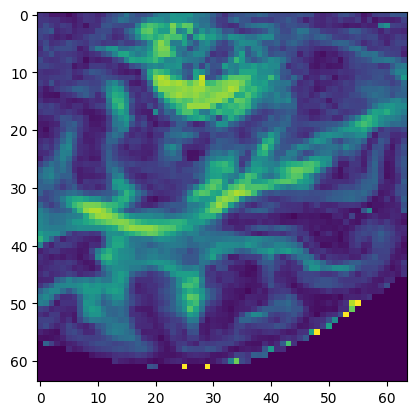

In [124]:
plt.imshow(hr[0,0,:,:,20].get())

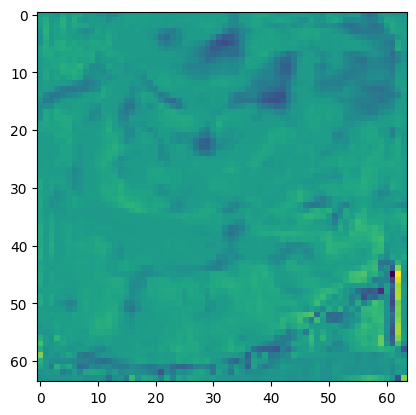

In [125]:
plt.imshow(pred[0,0,:,:,20].get())

In [129]:
l1_crit = nn.L1Loss()

In [133]:
l1_crit(torch.from_numpy(hr.get()), torch.from_numpy(pred.get()))

tensor(0.3859, dtype=torch.float64)

In [157]:
for batch in testing_data_loader:
        lr_tensor, hr_tensor = batch[0], batch[1]
        break

In [158]:
lr_tensor.shape

torch.Size([1, 35811, 173, 8])

In [237]:
temp = next(iter(testing_data_loader))
temp[0] = torch.permute(temp[0],(0,3,1,2))
print("input ",temp[0].shape)
t= pad(temp[0])
print("padded ",t[0].shape)
y = model(t[0])
print("output ",y.shape)
# print(t[1])
u = unpad(y,t[1][0],t[1][1],t[1][2],t[1][3])
print("unpadded ",u.shape)
out = u.reshape(1, 173, 207, 173, 5)
print(out.shape,temp[1].shape)


input  torch.Size([1, 8, 35811, 173])
padded  torch.Size([1, 8, 35824, 176])
output  torch.Size([1, 5, 35824, 176])
unpadded  torch.Size([1, 5, 35811, 173])
torch.Size([1, 173, 207, 173, 5]) torch.Size([1, 173, 207, 173, 5])


In [242]:
hr = cp.array(temp[1].squeeze())
pred = cp.array(out.squeeze().detach().numpy())

In [243]:
print(pred.shape,hr.shape)

(173, 207, 173, 5) (173, 207, 173, 5)


In [246]:
abs(float(met.structural_similarity(hr,pred,channel_axis =3,data_range=1)))

0.004395098183737425

In [185]:
temp[1].shape,out.shape

(torch.Size([1, 173, 207, 173, 5]), torch.Size([1, 173, 207, 173, 5]))

In [206]:
temp[1].shape
hr = torch.permute(temp[1],(0,4,1,2,3))
pred = torch.permute(out,(0,4,1,2,3))

In [217]:
pred.shape,hr.shape

(1, 5, 173, 207, 173)

In [218]:
hr.shape

(1, 5, 173, 207, 173)

In [262]:
print(len(training_data_loader))

27


In [219]:
hr = cp.array(hr)
pred = cp.array(pred)
met.structural_similarity(hr,pred,channel_axis=1,data_range=1)

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.